#Setup

In [ ]:
#tf.config.list_physical_devices('GPU')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Menggunakan GPU agar proses training lebih cepat

In [ ]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Membaca data dari dalam google drive agar tidak perlu melakukan upload berulang kali.

In [ ]:
import numpy as np
from ipywidgets import interact, widgets
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import imghdr


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras import optimizers
from keras import Model
from keras.utils import to_categorical


#Image augmentation

In [ ]:
#original_images_path = '/content/drive/MyDrive/Naratika/Gajah Oling'

#augmented_images_path = '/content/drive/MyDrive/Naratika/Gajah Oling Aug'

#if not os.path.exists(augmented_images_path):
#    os.makedirs(augmented_images_path)

#datagen = ImageDataGenerator(
#    rotation_range=40,
#    shear_range=0.2,
#    horizontal_flip=True,
#    vertical_flip=True,
#    fill_mode='nearest'
#)
#for filename in os.listdir(original_images_path):
#    if filename.endswith(('.jpeg','.jpg', '.bmp', '.png')):
#        img_path = os.path.join(original_images_path, filename)
#       img = image.load_img(img_path, target_size=(256, 256))  # Adjust the target size as needed
#        x = image.img_to_array(img)
#        x = x.reshape((1,) + x.shape)

#        i = 0
#        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_images_path, save_prefix='aug', save_format='jpg'):
#            i += 1
#            if i >= 3:
#                break
#for filename in os.listdir(augmented_images_path)[:5]:
#    img_path = os.path.join(augmented_images_path, filename)
#    img = image.load_img(img_path)
#    plt.imshow(img)
#    plt.axis('off')
#    plt.show()

Setiap image mendapatkan augmentasi sebanyak 2 atau 3 kali, sehingga total setiap kelas setidaknya 1000 gambar.

#Data Loading and Prepro

In [ ]:
data_dir = '/content/drive/MyDrive/Naratika/' #Writing the general directory before the classes

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png'] #Will be used to filter out incompatible image extensions

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Melakkukan filtering data agar directory image yang tidak sesuai dengan ekstensinya tidak digunakan.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Splitting the data into multiple batches with each batch has 32 images with 256 x 256 pixels
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = 32, image_size = (256,256))

Found 5424 files belonging to 5 classes.


Menggunakan tf.keras.utils.image_dataset_from_directory untuk membaca data dan memisahkannya menjadi 5 kelas sesuai dengan banyaknya sub-folder yang ada dalam folder Naratika dan memisahkannya menjadi batches dengan setiap batch berisi 32 gambar.

In [ ]:
import pandas as pd

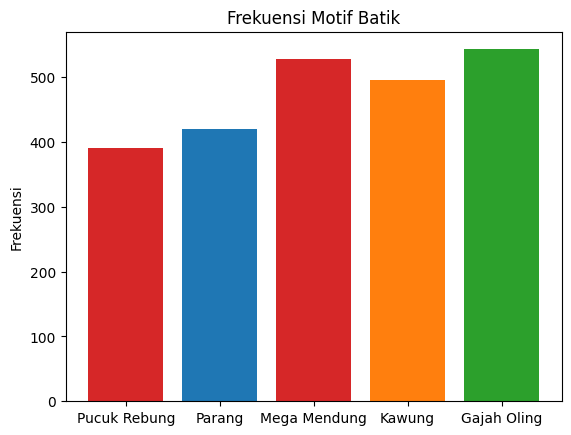

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

motif = ['Pucuk Rebung', 'Parang', 'Mega Mendung', 'Kawung', 'Gajah Oling']
freq = [390, 420, 528, 496, 543]
bar_labels = ['red', 'blue', '_red', 'orange', 'green']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:green']

ax.bar(motif, freq, label=bar_labels, color=bar_colors)

ax.set_ylabel('Frekuensi')
ax.set_title('Frekuensi Motif Batik')

plt.show()

In [ ]:
plt.xlabel('Motif Batik')
plt.ylabel('Frequency')
plt.title('Vertical Bar Plot of Motif Batik Frequencies')
plt.show()

#Seeing which class is assigned to which label

In [ ]:
class_names = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = 32, image_size = (256,256)).class_names

for i, class_name in enumerate(class_names):
    print(f"Class name: {class_name}, Integer label: {i}")

Found 5424 files belonging to 5 classes.
Class name: Gajah Oling, Integer label: 0
Class name: Kawung, Integer label: 1
Class name: Mega Mendung, Integer label: 2
Class name: Parang, Integer label: 3
Class name: Pucuk Rebung, Integer label: 4


Melihat label numerik apa diletakkan pada kelas mana

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

data_iterator.next() berguna untuk melihat batch selanjutnya untuk melihat gambar dan labelnya.

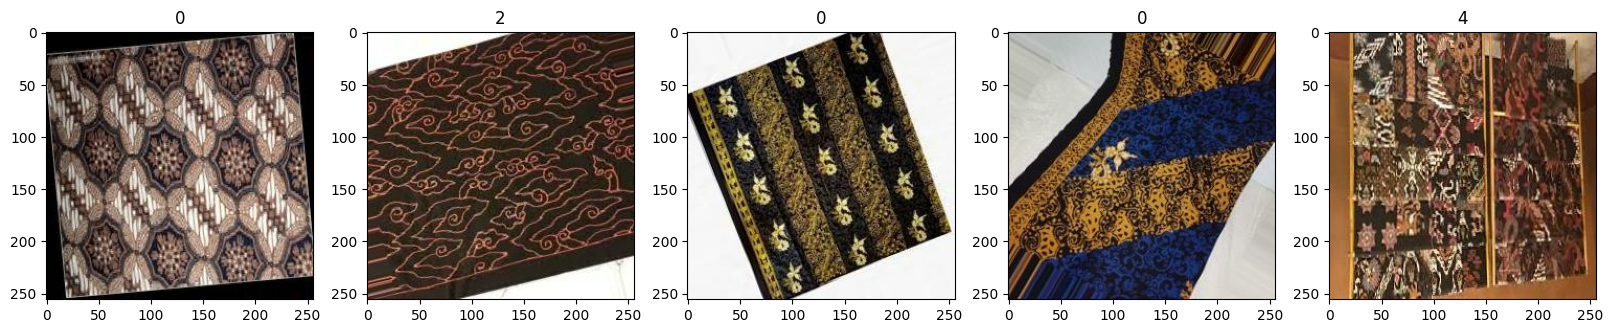

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][0:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#Scaling the data so that each value is between 0 and 1 instead of between 0 and 255

In [ ]:
data = data.map(lambda x,y: (x/255, y))

Melakukan scaling agar nilai setiap pixel berada pada 0-1 dan bukannya 0-255 agar model dapat bekerja dengan lebih baik

In [ ]:
len(data)

170

Melihat ada berapa banyak batch yang terbentuk

#Splitting the data into train batches and test batches

In [ ]:
train_size = int(len(data)*.7)
test_size = int(len(data)*.3)+1

Mengambil 70% dari total batch sebagai data train dan 30% dari total batch sebagai data test, +1 pada data test diperlukan karena pembulatan ke bawah yang dilakukan oleh python akan membuat train_size + test_size bernilai 169, bukannya 170 seperti jumlah batch awal.

In [ ]:
test_size

52

In [ ]:
train_size + test_size

170

The +1 in  'int(len(data)0.3)+1' is necessary because we want the total of train_size + test_size = 170 (the same as len(data).

In [ ]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

train = data.take(train_size) berguna untuk mengambil batch sebanyak train_size

test = data.skip(train_size).take(test_size) berguna untuk melewati batch yang sudah diambil oleh training dan mengambil data sebanyak test_size

#Building the model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model1 = Sequential()

In [ ]:
model1.add(Conv2D(16, (3,3), 1, activation='relu',kernel_regularizer=regularizers.l1(0.01), input_shape=(256,256,3)))
model1.add(MaxPooling2D())
model1.add(Conv2D(32, (3,3), 1, activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(16, (3,3), 1, activation='relu'))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(5, activation='softmax'))

The first convolution layer has 16 filters, scans 3x3

1.   The first convolution layer has 16 filters, scans 3x3 pixels, and move 1 pixel each time with activation function = relu (rectified linear unit) where each value is considered zero if its lower than zero but we keep each positive value as it is.

2.  The second convolution layer has 32 filters, scans 3x3 pixels, and move 1 pixel each time with relu activation function.

3.  The third convolution layer has 16 filters, scans 3x3 pixels, and move 1 pixel each time with relu activation function.

4.  The output layer is Dense(5, activation = 'softmax') because we want five outputs with different probabilites assigned for each class with the highest probability is the predicted class of an image.

In [ ]:
model1.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We use adam as the optimizer and sparse_categorical_crossentropy as the loss function because we encoded our dataset using 'tf.keras.utils.image_dataset_from_directory' that returns integer label instead of one hot encoding. And we want accuracy as the metrics used.

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 16)        0

#Logging

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Model_training

In [ ]:
hist = model1.fit(train, epochs=20, validation_data=test, callbacks=[tensorboard_callback])

Epoch 1/20
118/118 [==============================] - 23s 157ms/step - loss: 1.8264 - accuracy: 0.3890 - val_loss: 1.4988 - val_accuracy: 0.5455
Epoch 2/20
118/118 [==============================] - 30s 249ms/step - loss: 1.4616 - accuracy: 0.5307 - val_loss: 1.3520 - val_accuracy: 0.5850
Epoch 3/20
118/118 [==============================] - 19s 160ms/step - loss: 1.2946 - accuracy: 0.6022 - val_loss: 1.3270 - val_accuracy: 0.5953
Epoch 4/20
118/118 [==============================] - 18s 146ms/step - loss: 1.1189 - accuracy: 0.6708 - val_loss: 1.2221 - val_accuracy: 0.6232
Epoch 5/20
118/118 [==============================] - 15s 127ms/step - loss: 0.8786 - accuracy: 0.7654 - val_loss: 1.2009 - val_accuracy: 0.6426
Epoch 6/20
118/118 [==============================] - 15s 127ms/step - loss: 0.6254 - accuracy: 0.8607 - val_loss: 1.3304 - val_accuracy: 0.6432
Epoch 7/20
118/118 [==============================] - 17s 141ms/step - loss: 0.4770 - accuracy: 0.9129 - val_loss: 1.4586 - val_ac

We train our model using 20 epochs. We want our loss to decrease while our accuracy to increase, which is exactly what happened here so we are happy about it but because of overfitting, further architectural modification will be made

1. Class name: Gajah Oling, Integer label: 0
2. Class name: Kawung, Integer label: 1
3. Class name: Mega Mendung, Integer label: 2
4. Class name: Parang, Integer label: 3
5. Class name: Pucuk Rebung, Integer label: 4

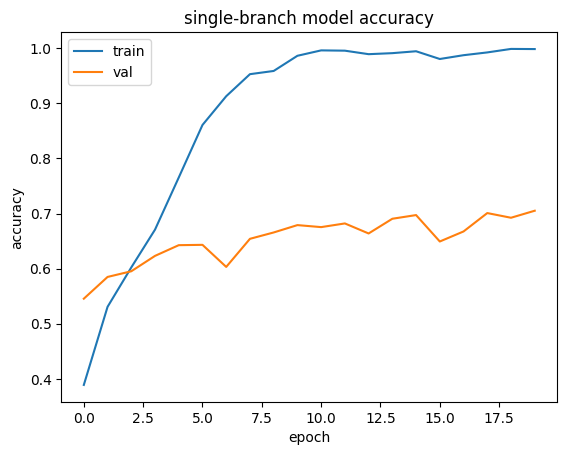

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('single-branch model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

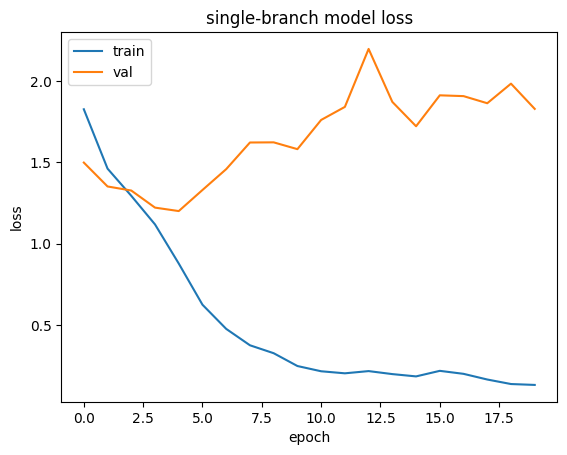

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('single-branch model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
batik_motif_dict = {
    0: 'Gajah Oling',
    1: 'Kawung',
    2: 'Mega Mendung',
    3: 'Parang',
    4: 'Pucuk Rebung'
}

Because the model outputs numbered labels, to ensure better readability, we create a dictionary of what label means what.

In [ ]:
images_to_predict_dir = ['Gajah Oling/aug_0_1001.jpg','Kawung/aug_0_1006.jpg','Mega Mendung/aug_0_101.jpg','Parang/aug_0_1.jpg','Pucuk Rebung/aug_0_10.jpg']

Filenames to test the model

In [ ]:
import re

1/1 [==============================] - 0s 16ms/step


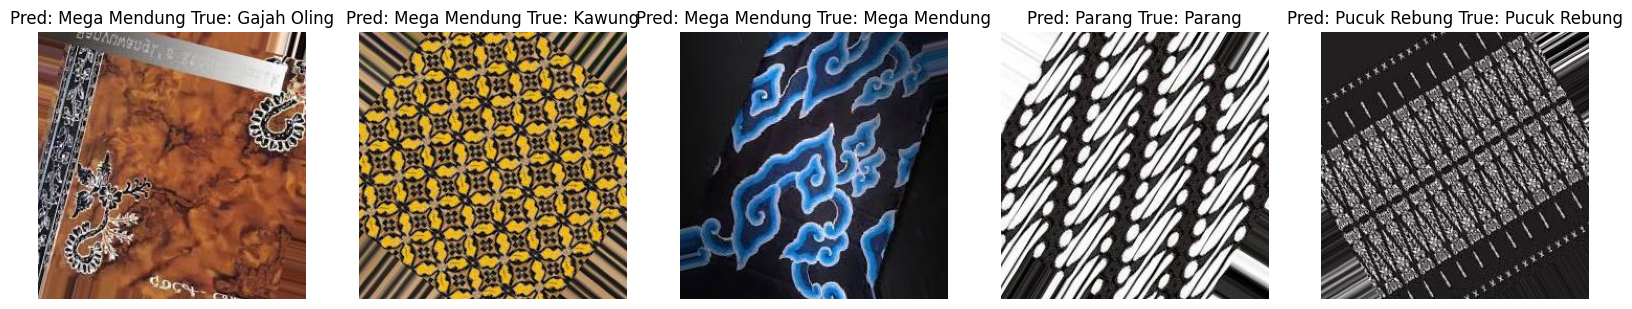

In [ ]:
fig, ax = plt.subplots(1, ncols = len(images_to_predict_dir), figsize=(20, 8))
for i in range(len(images_to_predict_dir)):
  img_loop = cv2.imread('/content/drive/MyDrive/Naratika/'+images_to_predict_dir[i]) #Load the image
  resize_loop = tf.image.resize(img_loop, (256,256)) #Resize the image
  yhat_loop = model1.predict(np.expand_dims(resize_loop/255, 0)) #Predict a scaled version of the image
  predicted_label_loop = np.argmax(yhat_loop) #Get the highest probability given out by the model as the predicted label

  img_rgb_loop = cv2.cvtColor(img_loop, cv2.COLOR_BGR2RGB) #To show the correct image
  ax[i].imshow(img_rgb_loop)


  ax[i].set_title(f"Pred: {batik_motif_dict[predicted_label_loop]} True: {re.search(r'(.*?)/', images_to_predict_dir[i]).group(1)}") #Putting the predicted label inside our dictionary
  ax[i].axis('off')

plt.show()

Above is a cell to sample several images from different classes and what the model predicted about them.

#Save model

In [ ]:
model1.save(os.path.join('models','batikclassifier2.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Multi Branch CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D

In [ ]:
input_layer = Input(shape=(256, 256, 3))

##Branch 1

In [ ]:
branch1 = Conv2D(32, (3, 3),1, activation='relu')(input_layer)
branch1 = MaxPooling2D((2, 2))(branch1)
branch1 = Conv2D(64, (3, 3),1, activation='relu')(branch1)
branch1 = MaxPooling2D((2, 2))(branch1)
branch1 = Conv2D(128, (3,3,),1, activation= 'relu')(branch1)
branch1 = MaxPooling2D((2,2))(branch1)

In [ ]:
branch2 = Conv2D(64, (3, 3),1, activation='relu', padding = 'same')(branch1)
branch2 = MaxPooling2D((2, 2))(branch2)
branch2 = Conv2D(128, (3, 3),1, activation='relu', padding = 'same')(branch2)
branch2 = MaxPooling2D((2, 2))(branch2)

In [ ]:
branch1 = GlobalAveragePooling2D()(branch1)
branch2 = GlobalAveragePooling2D()(branch2)

merged = concatenate([branch1, branch2], axis=1)
merged = Flatten()(merged)
merged = Dense(128, activation='relu')(merged)
output_layer = Dense(5,activation = 'softmax')(merged)

1. Cabang pertama
  - Konvolusi 2D dengan 32 filter, scanning grid 3x3, dan pergerakan 1 pixel setiap scanning, dan dengan fungsi aktivasi ReLu untuk input 256x256x3
  - MaxPooling2D dilakukan untuk hasil lapisan konvolusi pertama
  - Hasil MaxPooling2D untuk lapisan konvolusi pertama dimasukkan ke dalam lapisan konvolusi kedua dengan 64 filter, scanning grid 3x3, dan pergerakan 1 pixel setiap scanning, dan dengan fungsi aktivasi ReLu
  - MaxPooling2D dilakukan untuk hasil lapisan konvolusi kedua
  - Hasil MaxPooling2D untuk lapisan konvolusi kedua Konvolusi 2D dengan 128 filter, scanning grid 3x3, dan pergerakan 1 pixel setiap scanning, dan dengan fungsi aktivasi ReLu
  - MaxPooling2D dilakukan untuk hasil lapisan konvolusi ketiga
2. Cabang kedua
  - Konvolusi 2D dengan 64 filter, canning grid 3x3, dan pergerakan 1 pixel setiap scanning, dan dengan fungsi aktivasi ReLu untuk hasil dari MaxPooling2D cabang pertama
  - MaxPooling2D dilakukan untuk hasil lapisan konvolusi pertama
  - Hasil MaxPooling2D untuk lapisan konvolusi pertama dimasukkan ke dalam lapisan konvolusi kedua dengan 128 filter, scanning grid 3x3, dan pergerakan 1 pixel setiap scanning, dan dengan fungsi aktivasi ReLu
  - MaxPooling2D dilakukan untuk hasil lapisan konvolusi kedua
3. Output
  - GlobalAveragePooling2D dilakukan untuk cabang 1 agar ukuran sama dengan cabang 2 dan penggabungan bisa dilakukan
  - GlobalAveragePooling2D dilakukan untuk cabang 2 agar ukuran sama dengan cabang 1 dan penggabungan bisa dilakukan
  - Menggabungkan cabang 1 dan cabang 2 yang telah melalui GlobalAveragePooling2D
  - Flatten dilakukan untuk mengubah hasilnya penggabungan menjadi vektor 1 dimensi
  - Dilanjutkan dengan dense dengan 128 neuron, fungsi aktivasi ReLu
Lapisan output dengan 5 neuron dan fungsi aktivasi softmax digunakan karena terdapat 5 kelas untuk diprediksi.


In [ ]:
model_bmr = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [ ]:
model_bmr.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We use adam as the optimizer and sparse_categorical_crossentropy as the loss function because we encoded our dataset using 'tf.keras.utils.image_dataset_from_directory' that returns integer label instead of one hot encoding. And we want accuracy as the metrics used.

In [ ]:
model_bmr.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 254, 254, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 125, 125, 64)         18496     ['max_pooling2d[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

Training is done with 100 epochs and EarlyStopping callback with patience = 20 to monitor val_accuracy. EarlyStopping is used because we want to restore the best weights when val_accuracy does not improve after 20 epochs and stop the training.

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
hist1 = model_bmr.fit(train, epochs=100, validation_data=test, callbacks=[early_stopping_callback])

Epoch 1/100
118/118 [==============================] - 26s 145ms/step - loss: 1.3908 - accuracy: 0.3906 - val_loss: 1.2754 - val_accuracy: 0.4715
Epoch 2/100
118/118 [==============================] - 18s 145ms/step - loss: 1.2588 - accuracy: 0.4820 - val_loss: 1.2035 - val_accuracy: 0.4994
Epoch 3/100
118/118 [==============================] - 17s 139ms/step - loss: 1.1823 - accuracy: 0.5376 - val_loss: 1.1032 - val_accuracy: 0.5655
Epoch 4/100
118/118 [==============================] - 20s 167ms/step - loss: 1.0728 - accuracy: 0.6038 - val_loss: 0.9718 - val_accuracy: 0.6559
Epoch 5/100
118/118 [==============================] - 17s 140ms/step - loss: 1.0002 - accuracy: 0.6340 - val_loss: 0.9551 - val_accuracy: 0.6566
Epoch 6/100
118/118 [==============================] - 77s 657ms/step - loss: 0.9370 - accuracy: 0.6629 - val_loss: 0.9300 - val_accuracy: 0.6650
Epoch 7/100
118/118 [==============================] - 68s 141ms/step - loss: 0.9190 - accuracy: 0.6711 - val_loss: 0.8664 -

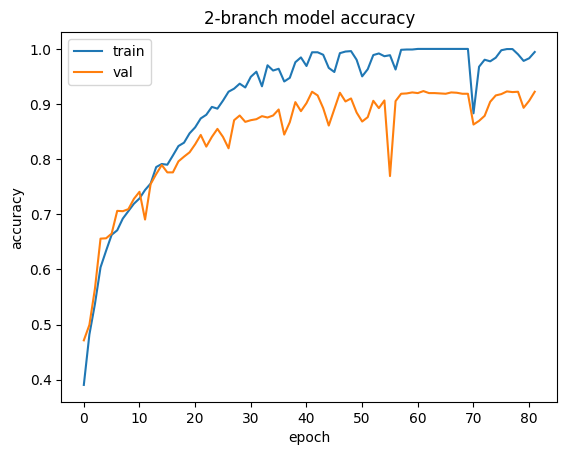

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('2-branch model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

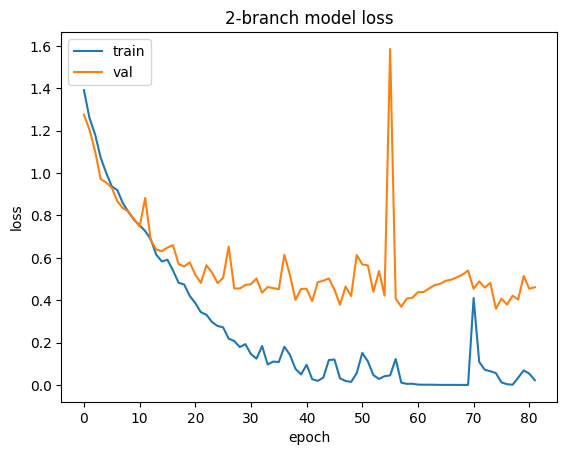

In [ ]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('2-branch model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_bmr.save(os.path.join('models','batikclassifier4.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
images_to_predict_dir = ['Gajah Oling/aug_0_1001.jpg','Kawung/aug_0_1006.jpg','Mega Mendung/aug_0_101.jpg','Parang/aug_0_1.jpg','Pucuk Rebung/aug_0_10.jpg']

File names to test the model

1/1 [==============================] - 0s 19ms/step


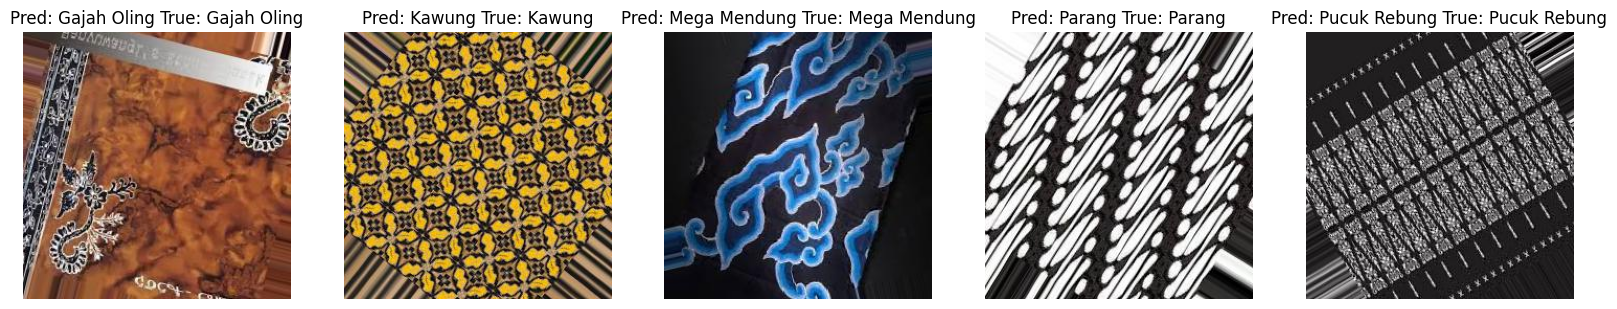

In [ ]:
fig, ax = plt.subplots(1, ncols = len(images_to_predict_dir), figsize=(20, 8))
for i in range(len(images_to_predict_dir)):
  img_loop = cv2.imread('/content/drive/MyDrive/Naratika/'+images_to_predict_dir[i]) #Load the image
  resize_loop = tf.image.resize(img_loop, (256,256)) #Resize the image
  yhat_loop = model_bmr.predict(np.expand_dims(resize_loop/255, 0)) #Predict a scaled version of the image
  predicted_label_loop = np.argmax(yhat_loop) #Get the highest probability given out by the model as the predicted label

  img_rgb_loop = cv2.cvtColor(img_loop, cv2.COLOR_BGR2RGB) #To show the correct image
  ax[i].imshow(img_rgb_loop)


  ax[i].set_title(f"Pred: {batik_motif_dict[predicted_label_loop]} True: {re.search(r'(.*?)/', images_to_predict_dir[i]).group(1)}") #Putting the predicted label inside our dictionary
  ax[i].axis('off')

plt.show()

In [ ]:
#new_model = load_model('imageclassifier.h5')